In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = "Mall_Customers.csv"
df = pd.read_csv(file_path)

In [3]:
df = df.drop(columns=["CustomerID"])

In [4]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

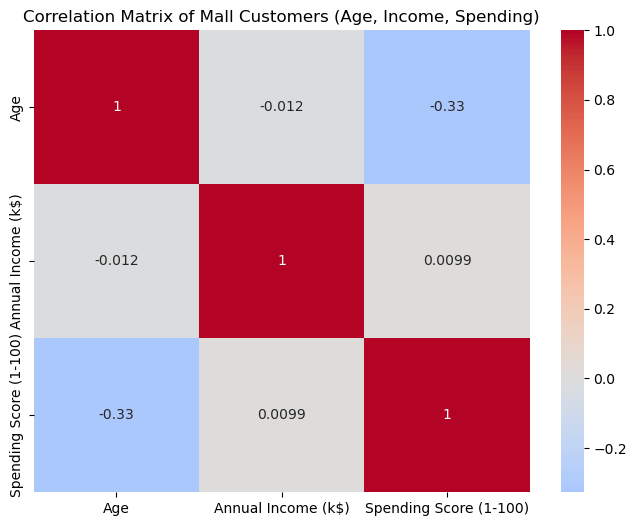

In [8]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Mall Customers (Age, Income, Spending)")
plt.show()

In [9]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


In [10]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [11]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

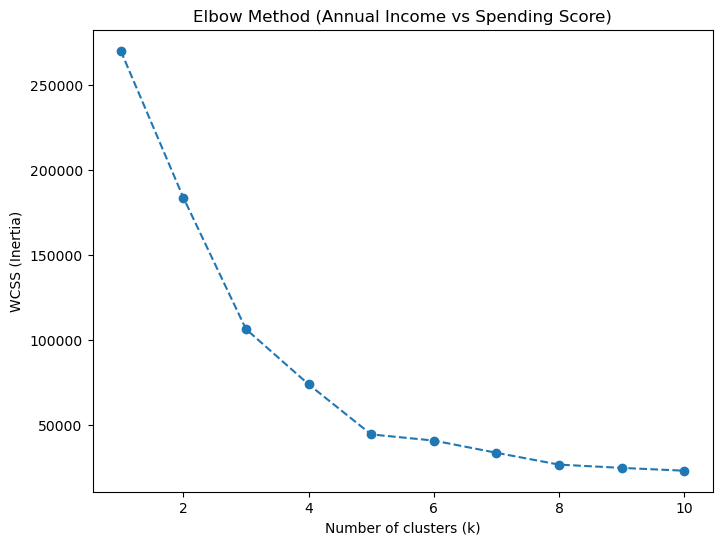

In [12]:
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method (Annual Income vs Spending Score)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)


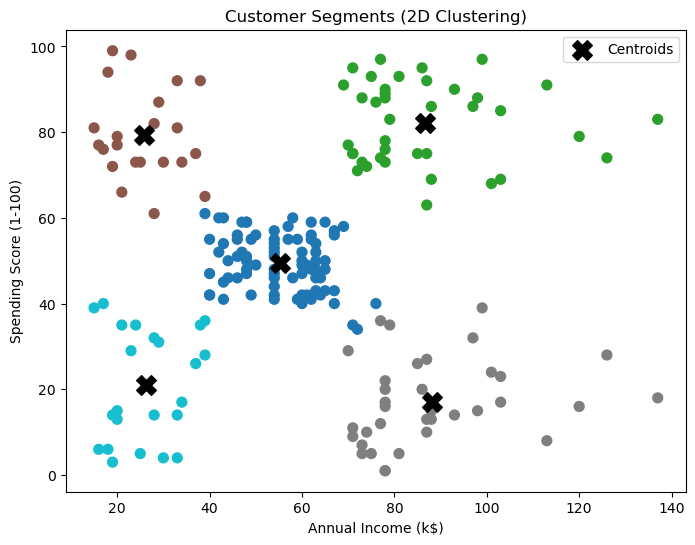

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(X.iloc[:,0], X.iloc[:,1],
            c=y_kmeans, cmap='tab10', s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            s=200, c='black', marker='X', label='Centroids')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Customer Segments (2D Clustering)")
plt.legend()
plt.show()


In [15]:
X3 = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

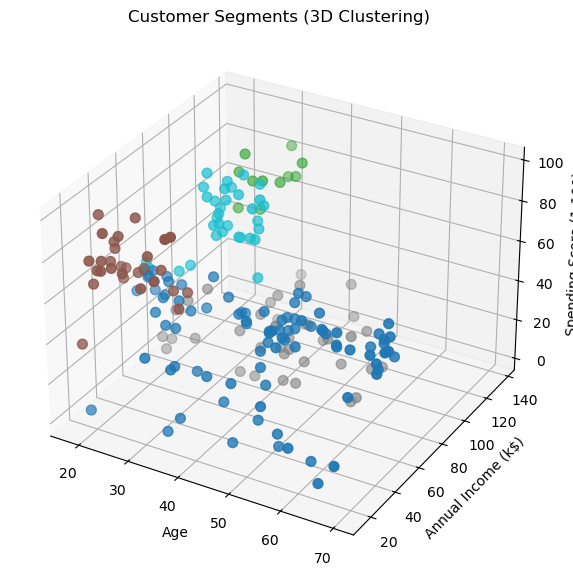

In [16]:
kmeans3 = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans3 = kmeans3.fit_predict(X3)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X3.iloc[:,0], X3.iloc[:,1], X3.iloc[:,2],
           c=y_kmeans3, cmap='tab10', s=50)

ax.set_xlabel("Age")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Spending Score (1-100)")
ax.set_title("Customer Segments (3D Clustering)")

plt.show()


In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [19]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")

Silhouette Score for k=2: 0.396
Silhouette Score for k=3: 0.468
Silhouette Score for k=4: 0.494
Silhouette Score for k=5: 0.554
Silhouette Score for k=6: 0.513
Silhouette Score for k=7: 0.502
Silhouette Score for k=8: 0.496
Silhouette Score for k=9: 0.456
Silhouette Score for k=10: 0.443


In [20]:
X3 = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

print("Silhouette Scores (3D: Age, Income, Spending):")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X3)
    score = silhouette_score(X3, labels)
    print(f"k={k}: {score:.3f}")

Silhouette Scores (3D: Age, Income, Spending):
k=2: 0.332
k=3: 0.336
k=4: 0.405
k=5: 0.358
k=6: 0.416
k=7: 0.442
k=8: 0.433
k=9: 0.409
k=10: 0.397


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [25]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [28]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", encoder, categorical_cols)
    ],
    remainder="drop"
)

In [33]:
kmeans_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", KMeans(n_clusters=3, random_state=42))
])

kmeans_pipeline.fit(df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)',
                                                   'cluster']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender'])])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [36]:
encoded_data = kmeans_pipeline.named_steps["preprocessor"].transform(df)

In [37]:
encoded_feature_names = (
    numerical_cols +
    list(kmeans_pipeline.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(categorical_cols))
)

In [38]:
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

# Add cluster labels
encoded_df["cluster"] = kmeans_pipeline.named_steps["kmeans"].labels_

# 🔹 Print the encoded data
print("🔹 Encoded Data (after OneHotEncoding & Scaling):\n")
print(encoded_df.head())


🔹 Encoded Data (after OneHotEncoding & Scaling):

        Age  Annual Income (k$)  Spending Score (1-100)  cluster  \
0 -1.424569           -1.738999               -0.434801        2   
1 -1.281035           -1.738999                1.195704        2   
2 -1.352802           -1.700830               -1.715913        2   
3 -1.137502           -1.700830                1.040418        2   
4 -0.563369           -1.662660               -0.395980        2   

   Gender_Female  Gender_Male  
0            0.0          1.0  
1            0.0          1.0  
2            1.0          0.0  
3            1.0          0.0  
4            1.0          0.0  


In [34]:
df["cluster"] = kmeans_pipeline.named_steps["kmeans"].labels_

In [35]:
print(df.head())
print("\nCluster centers shape:", kmeans_pipeline.named_steps["kmeans"].cluster_centers_.shape)

   Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0    Male   19                  15                      39        2
1    Male   21                  15                      81        2
2  Female   20                  16                       6        2
3  Female   23                  16                      77        2
4  Female   31                  17                      40        2

Cluster centers shape: (3, 6)
